In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd

import warnings
import sys
import os
warnings.filterwarnings("ignore")
sys.stderr = open(os.devnull, 'w')

# local crs
local_crs = 32636

In [2]:
from blocksnet.models import City
city_model = City.from_pickle("D:/1NOTEBOOKS/city_model_vas_ostrov.pickle")

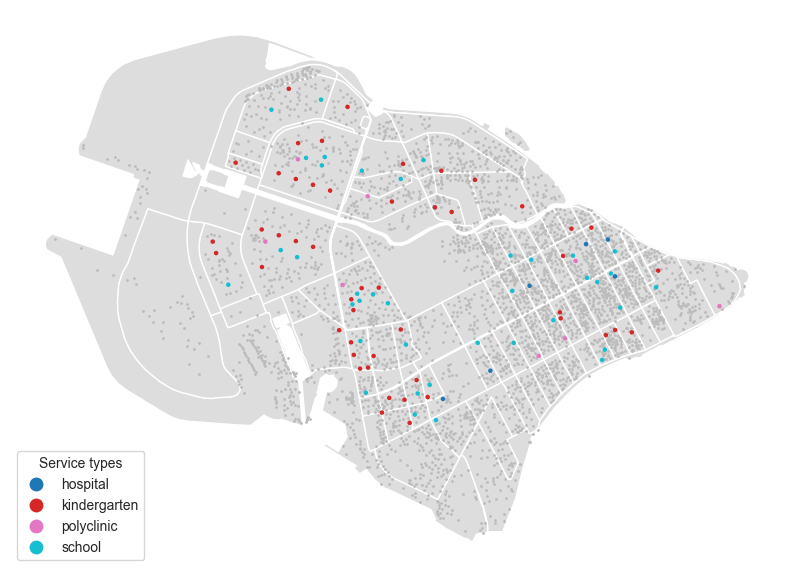

In [3]:
city_model.plot()

In [4]:
blocks = city_model.get_blocks_gdf()

In [5]:
from blocksnet.method import Provision
prov = Provision(city_model=city_model)

In [6]:
vacant_area = gpd.read_file("D:/1NOTEBOOKS/data/vacant_area_results_ALL2.geojson").to_crs(local_crs)

In [7]:
vacant_area

,id,area,length,geometry
0,None,583.140555,120.584587,"POLYGON ((343789.017 6646857.247, 343788.913 6..."
1,None,951.919646,127.926256,"POLYGON ((343562.276 6647209.954, 343562.384 6..."
2,None,1819.541607,298.167092,"POLYGON ((343746.552 6647192.582, 343746.594 6..."
3,None,17547.962111,874.085845,"POLYGON ((343849.538 6647215.288, 343849.628 6..."
4,None,541.997440,149.141419,"POLYGON ((343676.772 6647228.079, 343676.671 6..."
...,...,...,...,...
539,None,857.479262,217.356366,"POLYGON ((345399.470 6647750.662, 345397.555 6..."
540,None,830.131023,196.813477,"POLYGON ((345299.920 6647817.935, 345299.814 6..."
541,None,1612.062629,204.075232,"POLYGON ((347971.432 6648156.132, 347971.332 6..."
542,None,292.344178,69.245740,"POLYGON ((348209.112 6647915.186, 348209.221 6..."


In [8]:
blocks = city_model.get_blocks_gdf()

In [9]:
vacant_area_with_blocks = gpd.sjoin(vacant_area, blocks, how = 'inner')

In [11]:
service_type = 'school'

In [12]:
calc = prov.calculate(service_type, method = 'iterative')

In [13]:
def choose_location(calc, vacant_area_with_blocks, service_type : str):
    i = 0
    while True:
        selected_block = calc.sort_values(by = 'demand_without', ascending=False).iloc[i]
        i+=1
        if selected_block.provision == 1: #дошли до блоков, которые полностью удовлетворены
            print('Нет подходящих мест')
            return None
        block_vacant_area = vacant_area_with_blocks[vacant_area_with_blocks['index_right'] == selected_block.name] # получили всю вакант ареа
        SERVICE_CODES = {"school" : 0, "hospital" : 1}                                                             # для выбранного блока
        
        SERVICE_BRICKS = [
            {
                "name" : "school",
                "bricks" : [
                    {"capacity": 100, "area": 5500},
                    {"capacity": 300, "area": 11000},
                    {"capacity": 600, "area": 15000},
                    {"capacity": 1100, "area": 25000},
                    {"capacity": 1500, "area": 30000},
                ]
            },
            {
                "name" : "hospital",
                "bricks" : [
                    {"capacity": 100, "area": 5500},
                    {"capacity": 300, "area": 11000},
                    {"capacity": 600, "area": 15000},
                    {"capacity": 1100, "area": 25000},
                    {"capacity": 1500, "area": 30000},
                ]
            }
        ]
        
        service_code = SERVICE_CODES[service_type] # service type
        bricks = SERVICE_BRICKS[service_code]['bricks']
       
        for j in range (len(bricks)-1, -1, -1):
            chosen_brick = bricks[j]
            min_area = chosen_brick['area']       
            filtered_vacant_area = block_vacant_area[block_vacant_area['area'] > min_area] #вакант ареа подходящая по    
            if filtered_vacant_area.empty:
                continue    
            min_area_row = filtered_vacant_area.loc[filtered_vacant_area['area'].idxmin()]
            return gpd.GeoDataFrame(min_area_row.to_frame().T, geometry='geometry', crs = local_crs)        

In [14]:
res = choose_location(calc, vacant_area_with_blocks, service_type)

<Axes: >

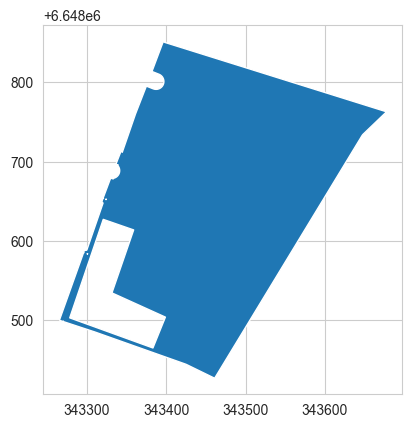

In [15]:
res.plot()

In [16]:
res

,id,area,length,geometry,index_right
24,None,84928.44572,1810.122058,"POLYGON ((343268.673 6648499.033, 343268.566 6...",99
